
# Adaptive PDE discretizations on Cartesian grids, Taichi implementations

## Volume : Proximal methods

## Part : Ballistic Benamou-Brenier formulations

## Chapter : Burgers' equation with optional viscosity, GPU experiments

$\DeclareMathOperator*\argmin{argmin}\DeclareMathOperator\prox{prox}$



We copy-paste some code of the tiBurgers notebook, and run a few large test cases on the GPU.

Tested using a 8GB Nvidia GPU, equivalent to 2060 class. 
Anything less powerfull will lead to long computation times.

## 0. Imports

In [1]:
import taichi as ti
import torch
import numpy as np
import scipy.fft
from copy import deepcopy
from matplotlib import pyplot as plt

cmul = ti.math.cmul; cconj = ti.math.cconj
π = np.pi

[Taichi] version 1.7.2, llvm 15.0.7, commit 0131dce9, osx, python 3.11.11


[I 03/25/25 14:54:25.291 4420193] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
#device = 'cuda';
device = 'mps'; agd_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations"; agdt_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AGDT/AdaptiveGridDiscretizations_Taichi"
import sys; sys.path.insert(0,agd_path); sys.path.insert(0,agdt_path)

from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
norm = ad.Optimization.norm
norminf = ad.Optimization.norm_infinity
from agd.Plotting import savefig
from agd import FiniteDifferences as fd

from agdt.Proximal import Proj,Misc,Prox
from agdt.Proximal.Misc import ticplx,cnorm2
#from BBB.misc import dtypeConversions,ticplx,cnorm2
#from BBB.proj import mk_proj_even,mk_proj_odd

In [3]:
ti.init(arch=ti.cpu,default_fp=ti.f64) # Default data types are f32 et i32

[Taichi] Starting on arch=x64


In [89]:
#savefig.dirName = "C:/Users/jmmir/Dropbox/Latex/2025/Illustrations/BBB/Burgers_GPU"
def aname(s): return {'ρ':'rho','ϕ':'phi'}.get(s,s)

## 1. Pasted code

In [5]:
def mk_proj_Burgers(dt,dx,ρ,ν=None):
    """Build the orthogonal projection onto Dtρ+Dxm=0, a=-ν*Dxρ, m'=m, a'=a, and parity constraints"""
    # Data types and conversions
    np_float_t = Misc.convert_dtype['np'][ρ.dtype]
    float_t = Misc.convert_dtype['ti'][np_float_t]
    cplx = ti.lang.matrix.VectorType(2,float_t) # !! use ti.math.cmul, etc
    π = np_float_t(np.pi) 
    shape=ρ.shape
    proj_even = Proj.mk_proj_even(float_t); proj_odd = Proj.mk_proj_odd(float_t)
    fft = Misc.get_fft_module(ρ)
    
    # Compute the Fourier transform of differential operators
    ξt = np.arange(shape[0],dtype=np_float_t)/shape[0]
    FDt = (np.exp(2j*π*ξt)-1)/dt
    ξx = np.arange(shape[1],dtype=np_float_t)/shape[1]
    FDx = (np.exp(2j*π*ξx)-1)/dx
    νFDxx = ν*(FDx.real**2+FDx.imag**2) if ν is not None else 0*FDx.real

    
    @ti.kernel # Without viscosity
    def proj_ti(        
        Fm:   ti.types.ndarray(dtype=cplx,ndim=2), # t,x
        Fρ:   ti.types.ndarray(dtype=cplx,ndim=2), # t,x
        FDt:  ti.types.ndarray(dtype=cplx,ndim=1), # t
        FDx:  ti.types.ndarray(dtype=cplx,ndim=1)):# x  
        for t,x in Fρ:
            vv = 2*cnorm2(FDt[t])+cnorm2(FDx[x]) # Factor 2 accounts for doubled weight of m 
            if vv>0:
                xv = 2*cmul(cconj(-FDt[t]),Fm[t,x])+cmul(cconj(FDx[x]),Fρ[t,x])
                xv /= vv
                Fm[t,x] = cmul(-FDt[t], xv)
                Fρ[t,x] = cmul(FDx[x],  xv)
    
    @ti.kernel # With viscosity
    def proj_nu_ti(
        Fm:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x
        Fρ:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x
        Fa:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x 
        FDt:  ti.types.ndarray(dtype=cplx,ndim=1),# t
        FDx:  ti.types.ndarray(dtype=cplx,ndim=1),# x 
        νFDxx:ti.types.ndarray(dtype=float_t,ndim=1),# x 
    ):
        for t,x in Fρ:
            vv = 2*cnorm2(FDt[t])+cnorm2(FDx[x])+2*νFDxx[x]**2 # Factor 2 accounts for doubled weight of m and a
            if vv>0:
                xv = 2*cmul(cconj(-FDt[t]),Fm[t,x])+cmul(cconj(FDx[x]),Fρ[t,x])+2*νFDxx[x]*Fa[t,x]
                xv /= vv
                Fm[t,x] = cmul(-FDt[t], xv)
                Fρ[t,x] = cmul(FDx[x],  xv)
                Fa[t,x] = νFDxx[x] * xv *1

    def proj(m0,m1,ρ,inplace=True):
        if not inplace: m0 = deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ)
        m = (m0+m1)/2
        proj_odd(m); proj_even(ρ)
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ)
        proj_ti(ticplx(Fm),ticplx(Fρ),ticplx(FDt),ticplx(FDx))
        m0[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; m1[:]=m0;
        return m0,m1,ρ
        
    def proj_nu(m0,m1,ρ,a0,a1,inplace=True):
        if not inplace: m0 = deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ); a0=deepcopy(a0); a1=deepcopy(a1)
        m = (m0+m1)/2; a=(a0+a1)/2
        proj_odd(m); proj_even(ρ); proj_even(a)
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ); Fa = fft.fftn(a)
        proj_nu_ti(ticplx(Fm),ticplx(Fρ),ticplx(Fa),ticplx(FDt),ticplx(FDx),νFDxx)
        Fa[0,0]=0 # zero frequency in both time and space needs separate handling 
        m0[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; a0[:] = fft.ifftn(Fa).real; m1[:]=m0; a1[:]=a0
        return m0,m1,ρ,a0,a1
        
    return proj if ν is None else proj_nu

In [6]:
def mk_prox_Burgers(F,ν=None):
    Nt2,Nx = F.shape
    Nt = Nt2//2
    np_float_t = Misc.convert_dtype['np'][F.dtype]
    float_t = Misc.convert_dtype['ti'][np_float_t]
    prox_perspective = Prox.mk_prox_perspective_vec(2,float_t) # Two-dimensional vector version
    vec2 = ti.lang.matrix.VectorType(2,float_t)
    is2 = np_float_t(1/np.sqrt(2))
    field = ti.types.ndarray(dtype=float_t,ndim=2) #t,x
    
    @ti.kernel # Without viscosity
    def prox_ti(τ:float_t,m0:field,m1:field,ρ:field,F:field): #t,x
        for t,x0 in ti.ndrange(Nt2,Nx):
            x1 = (x0+1)%Nx 
            M0 = m0[t,x0]+τ*F[t,x0]
            M1 = m1[t,x1]+τ*F[t,x1]
            if t==nT: # Prox of quadratic
                ρ[t,x0] = 1
                m0[t,x0] = M0/(1+τ)
                m1[t,x1] = M1/(1+τ)
            else: # Prox of perspective
                ρ[t,x0],v = prox_perspective(τ,ρ[t,x0],vec2(M0,M1))
                m0[t,x0]=v[0]
                m1[t,x1]=v[1]

    @ti.kernel
    def prox_nu_ti(τ:float_t,m0:field,m1:field,ρ:field,a0:field,a1:field,F:field): #t,x
        for t,x0 in ti.ndrange(Nt2,Nx): 
            ϵ = 1-2*(t>=Nt)
            x1 = (x0+1)%Nx
            M0 = ϵ*(m0[t,x0]+τ*F[t,x0])
            M1 = ϵ*(m1[t,x1]+τ*F[t,x1])
            A0 = a0[t,x0]; A1 = a1[t,x1]
            
            B0 = is2*(M0+A0); C0 = is2*(M0-A0)
            B1 = is2*(M1+A1); C1 = is2*(M1-A1)
            V0:float_t = np.nan; V1:float_t = np.nan # Dummy initialization
            if t==nT: # Prox of quadratic
                ρ[t,x0] = 1
                V0 = B0/(1+2*τ)
                V1 = B1/(1+2*τ)
            else: # Prox of perspective
                ρ[t,x0],v = prox_perspective(2*τ,ρ[t,x0],vec2(B0,B1))
                V0 = v[0]; V1=v[1]
            m0[t,x0] = ϵ*is2*(V0+C0)
            m1[t,x1] = ϵ*is2*(V1+C1)
            a0[t,x0] =   is2*(V0-C0)
            a1[t,x1] =   is2*(V1-C1)
    
    def prox(m0,m1,ρ,τ,inplace=True):
        """Inplace proximal operator for Burgers, without viscosity.
        - m0,m1 : centered in space, staggered in time.
        - ρ : staggered in space, centered in time.
        """
        if not inplace: m0=deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ)
        prox_ti(τ,m0,m1,ρ,F)
        return m0,m1,ρ
    def prox_ν(m0,m1,ρ,a0,a1,τ,inplace=True):
        """Inplace proximal operator for Burgers, with viscosity
        - a0,a1 : centered in space and time
        """
        if not inplace: m0=deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ); a0=deepcopy(a0); a1=deepcopy(a1)
        prox_nu_ti(τ,m0,m1,ρ,a0,a1,F)
        return m0,m1,ρ,a0,a1
        
    return prox if ν is None else prox_ν

In [7]:
def run_CP(u0,dt,dx,nT,τ_f=1,verb=0,maxiter=1000):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    rhs = np.zeros((nT+1,nX))
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    dt,dx,τ_f,Nu0 = map(np_float_t,(dt,dx,τ_f,Nu0))

    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m0 = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    m1 = m0.copy()
    if xp is not np: 
        m0,m1,ρ,Rhs = [Misc.asarray(e,like=u0_xp,dtype=u0_xp.dtype) for e in (m0,m1,ρ,Rhs)]
    x = Misc.asobjarray(m0,m1,ρ) 
    y = 0*x # Dual variable
    tx = deepcopy(x)

    # Proximal operators and time steps
    prox_f = Misc.useobjarray(mk_prox_Burgers(Rhs))
    prox_g = Misc.useobjarray(mk_proj_Burgers(dt,dx,ρ))
    def prox_gs(y,τ=1): return y-prox_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,maxiter)
    return x[0]*Nu0,x[1]*Nu0,x[2] # Put back the normalization

In [8]:
def run_CP_ν(u0,ν,dt,dx,nT,τ_f=1,verb=0,maxiter=1000):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
#    Nu0 = 1 # Avoid the time rescaling by setting Nu0=1
    u0 = u0/Nu0
    dt = dt*Nu0
    ν = ν/Nu0
    rhs = np.zeros((nT+1,nX))
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    dt,dx,τ_f,Nu0 = map(np_float_t,(dt,dx,τ_f,Nu0))

    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m0 = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    m1 = m0.copy()
    a0 = np.zeros_like(ρ)
    a1 = a0.copy()
    if xp is not np: 
        m0,m1,ρ,a0,a1,Rhs = [Misc.asarray(e,like=u0_xp,dtype=u0_xp.dtype) for e in (m0,m1,ρ,a0,a1,Rhs)]
    x = Misc.asobjarray(m0,m1,ρ,a0,a1) 
    y = 0*x # Dual variable
    tx = deepcopy(x)

    # Proximal operators and time steps
    prox_f = Misc.useobjarray(mk_prox_Burgers(Rhs,ν))
    prox_g = Misc.useobjarray(mk_proj_Burgers(dt,dx,ρ,ν))
    def prox_gs(y,τ=1): return y-prox_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1./τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,maxiter)
    return x[0]*Nu0,x[1]*Nu0,x[2],x[3]*Nu0,x[4]*Nu0 # Put back the normalization

In [9]:
def νBurgers_exact(t,x,ν,Re):
    """
    Exact solution, viscous, quickly decreasing.
    Important : the factor sqrt(2) previously in Wikipedia was erroneous. (Now corrected.)
    """
    from scipy.special import erfc
    α = np.exp(Re)-1
    return np.sqrt(ν/(π*t)) * α *np.exp(-x**2/(4*ν*t)) /(1+α*erfc(x/np.sqrt(4*ν*t))/2)

def deduplicate(m0,m1,ρ,a0=None,a1=None):
    """
    De-duplicate the unknowns used in the proximal solver
    Input : 
    - m0,m1 : staggered in time, centered in space, defined over [0,2T[ (antisym)
    - ρ : centered in time, staggered in space, defined over [0,2T[ (sym)
    - a0,a1 : centered in time and space, defined over [0,2T[ (sym)
    Output : 
    - m,ρ,a : staggered in time, centered in space, defined over [0,T[
    """
    m = (m0+m1)/2
    m = (m[:nT]-m[nT:][::-1])/2 # Anti-symmetry
    iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
    iρ = (np.roll(iρ,1,axis=1)+iρ)/2
    if a0 is None: return m,1/iρ
    a = (a0+a1)/2
    a = (a[:nT]+a[nT:][::-1])/2
    return m,1/iρ,a

## 2. Smooth test case

In [10]:
nT = 50
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)

Times plotted : [0.136 0.226 0.316 0.406 0.496 0.586 0.676 0.766 0.856 0.946]


In [11]:
%%time
ν = 1e-2 
Re=5
u0 = νBurgers_exact(t0,X-0.4,ν,Re)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0,ν,dt,dx,nT,τ_f=1,maxiter=2000)
m_ti,ρ_ti,a_ti = deduplicate(m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)
u = (m_ti+a_ti)/ρ_ti
#u[ρ_ti<1e-2]=0

CPU times: total: 2.42 s
Wall time: 7.98 s


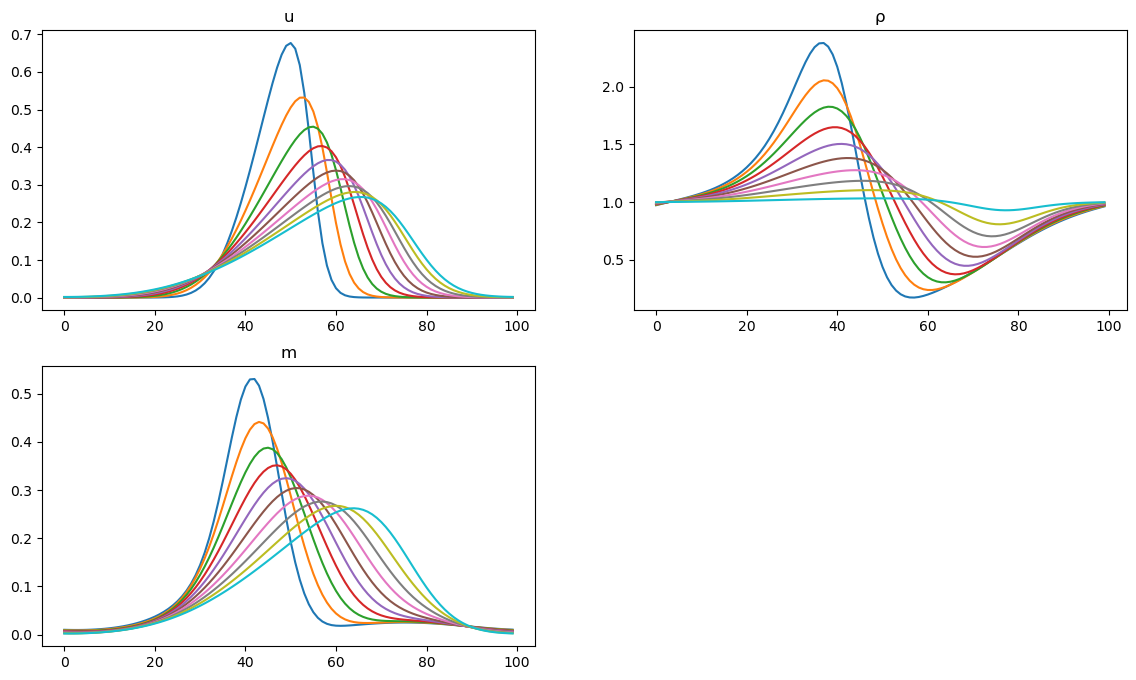

In [12]:
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ_ti,"ρ"),(m_ti,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

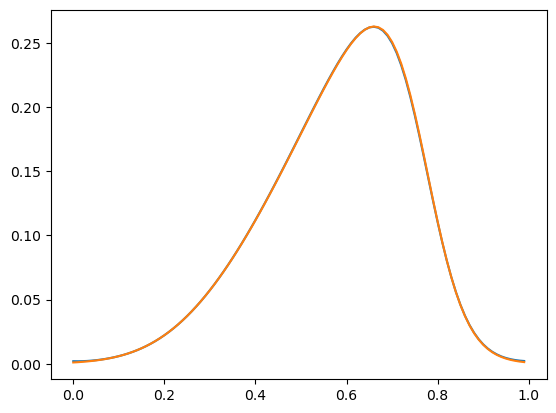

In [13]:
iT = nT-1
t = t0+(iT+0.5)*dt
plt.plot(X,u[iT])
plt.plot(X,νBurgers_exact(t,X-0.4,ν,Re));

### 2.1 Running on the GPU

Scales well to relatively large test cases 1024 x 2048. However, we have some issue with convergence in the latter iterations.

- 512t  1024x : 4000 primal-dual iterations needed for nice convergence (19.2s)
- 1024t 2048x : 8000 primal-dual iterations needed for nice convergence (1min35s)

The increasing number of iterations is a bit annoying : it means that there is something wrong with the rescaling, since we expect to converge to an algorithm in the continuous domain.

In [78]:
ti.init(arch=ti.gpu,default_fp=ti.f32)

[Taichi] Starting on arch=cuda


In [79]:
%%time
nT = 1024; nX=2048; maxiter=8000
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-2 
Re=5
u0 = νBurgers_exact(t0,X-0.4,ν,Re)

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1,maxiter=maxiter)

CPU times: total: 1min 30s
Wall time: 1min 35s


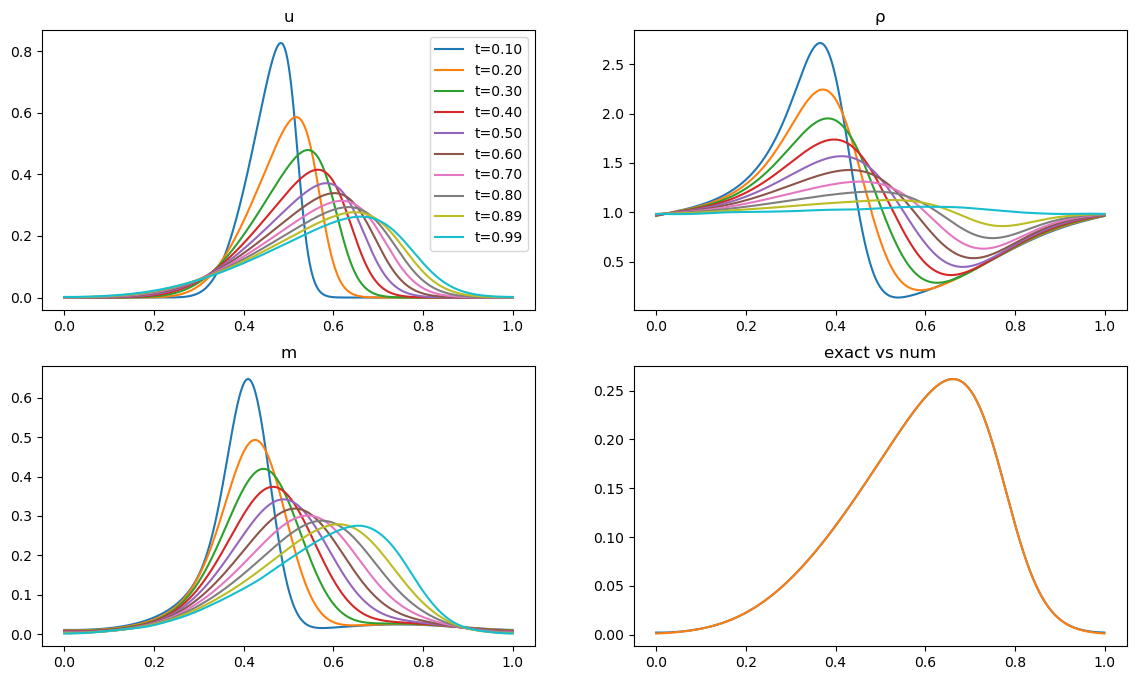

In [92]:
m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name=='u': plt.legend()
    savefig(fig,f'smooth_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

plt.subplot(2,2,4); plt.title("exact vs num")
iT = nT-1
t = t0+(iT+0.5)*dt
plt.plot(X,u[iT])
plt.plot(X,νBurgers_exact(t,X-0.4,ν,Re));

## 3. Step

The behavior is nice, but we need very many primal-dual iterations to converge...

In [114]:
%%time
nT = 512; nX=1024; maxiter=6000
t0 = 0. # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.2
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-3
u0 = np.logical_and(0.15<=X,X<0.65)

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1/20,maxiter=maxiter)

CPU times: total: 26.6 s
Wall time: 28.2 s


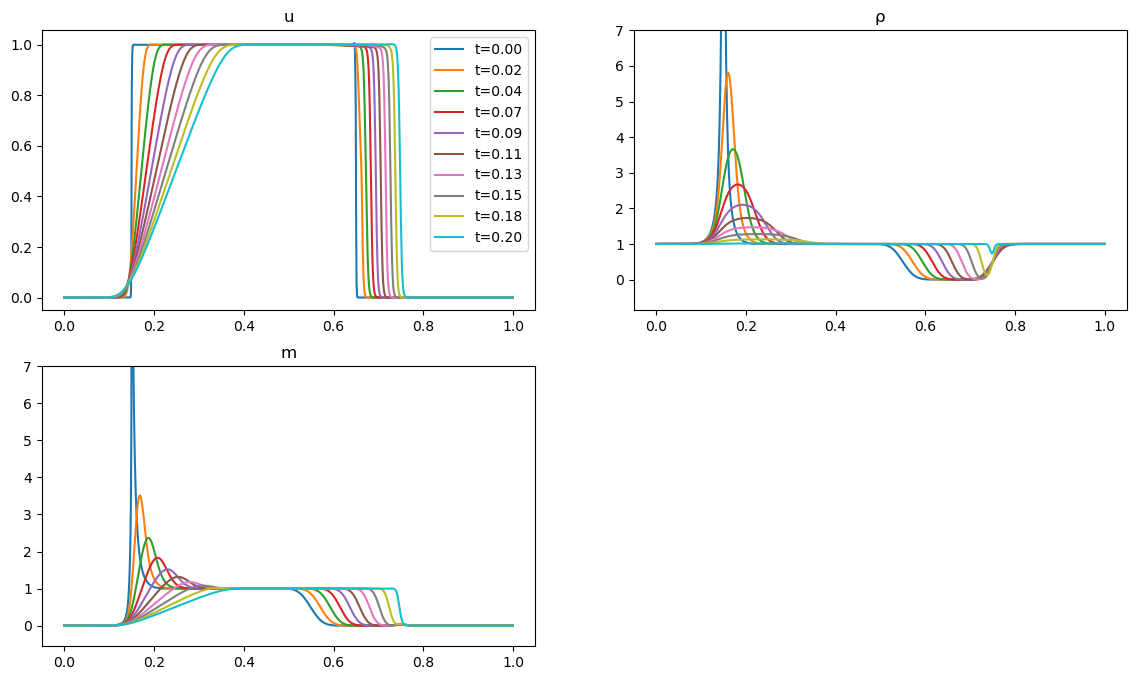

In [122]:
m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name in ('ρ','m'): plt.ylim(top=7)
    if name=='u': plt.legend()
    savefig(fig,f'step_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

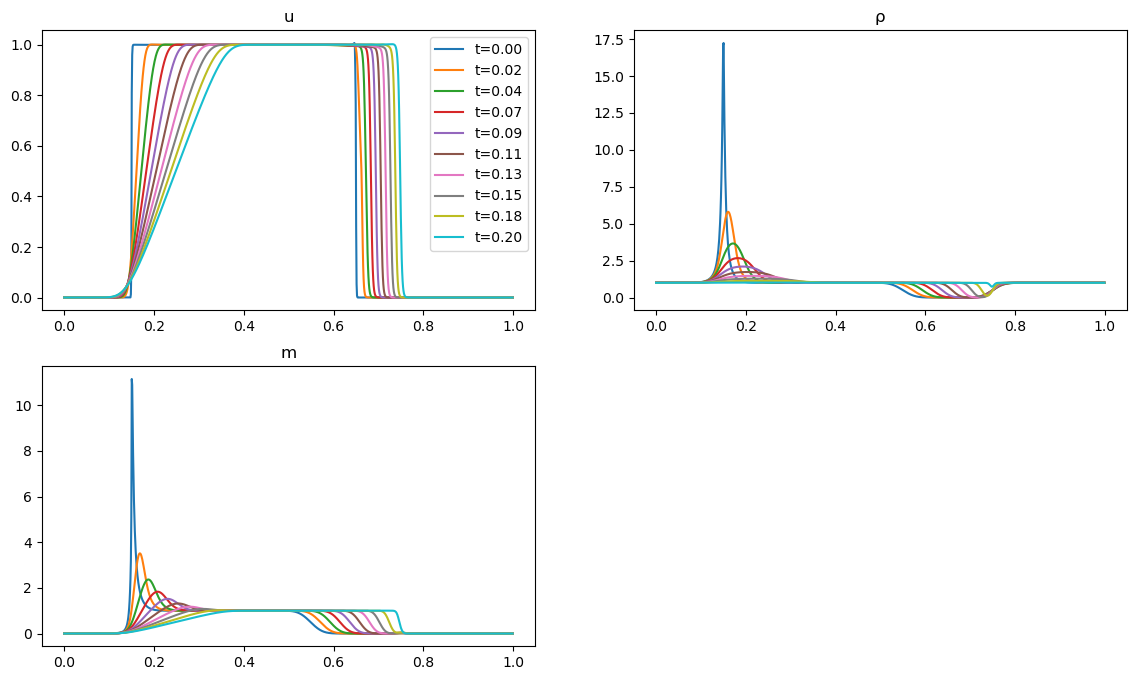

In [101]:
m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name=='u': plt.legend()
    savefig(fig,f'step_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

We can save some iterations by using a smaller $\tau_f$ proximal step. Again, there could be some scaling issue here.

In [60]:
%%time
nT = 512
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.3
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 1024
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-3
u0 = np.logical_and(0.15<=X,X<0.65)

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1/40,maxiter=2000)

CPU times: total: 10.5 s
Wall time: 10.5 s


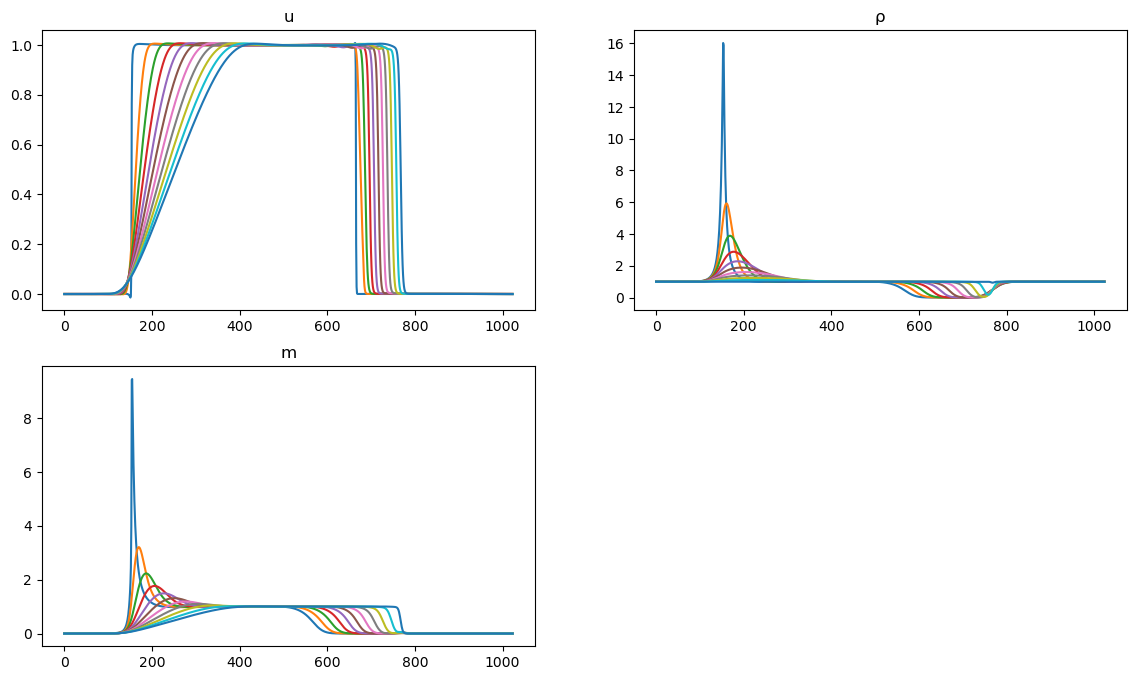

In [61]:
m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//10): plt.plot(var[i])

**Non-viscous**

The bottom line is that the numerics do not work.
Convergence is extremely slow, and the first time steps are not resolved in any satisfactory way, on the side of the shock.

CPU times: total: 3min
Wall time: 3min 26s


C:\Users\jmmir\AppData\Local\Temp\ipykernel_42224\500644126.py:22: RuntimeWarning: divide by zero encountered in divide
  iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
<timed exec>:17: RuntimeWarning: divide by zero encountered in divide
<timed exec>:17: RuntimeWarning: invalid value encountered in divide


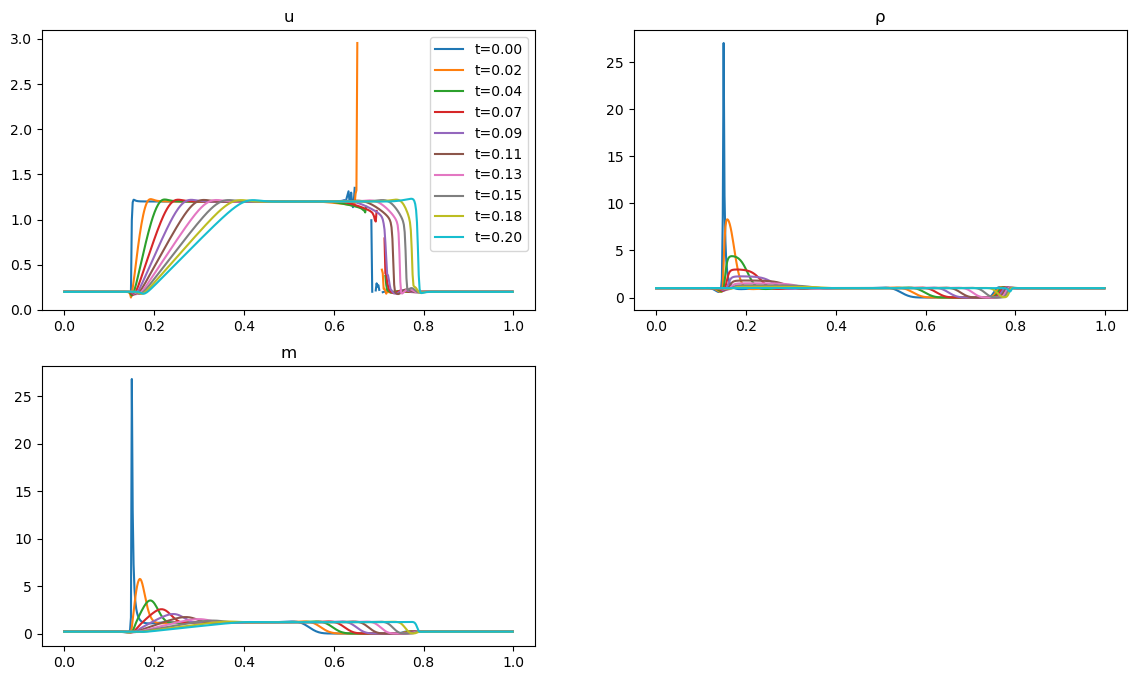

In [123]:
%%time
nT = 256; nX=512; maxiter=40000 #512, 1024
t0 = 0. # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.2
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 512 #1024
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 0
u0 = 0.2+np.logical_and(0.15<=X,X<0.65)

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1/40,maxiter=40000)

m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name=='u': plt.legend()
#    savefig(fig,f'nonviscous_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

C:\Users\jmmir\AppData\Local\Temp\ipykernel_42224\529218744.py:1: RuntimeWarning: divide by zero encountered in divide
  u = np.where(ρ>1e-6,(m+a)/ρ,np.nan)
C:\Users\jmmir\AppData\Local\Temp\ipykernel_42224\529218744.py:1: RuntimeWarning: invalid value encountered in divide
  u = np.where(ρ>1e-6,(m+a)/ρ,np.nan)


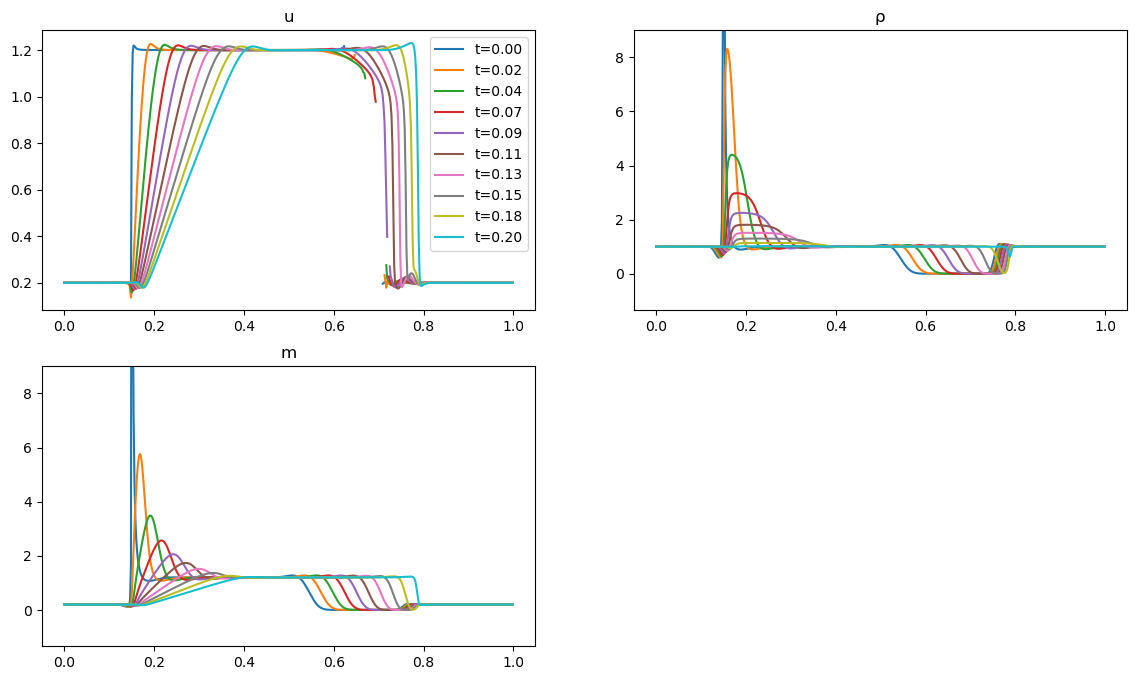

In [128]:
u = np.where(ρ>1e-6,(m+a)/ρ,np.nan)

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name=='u': plt.legend()
    if name in ('ρ','m'): plt.ylim(top=9)
    savefig(fig,f'nonviscous_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

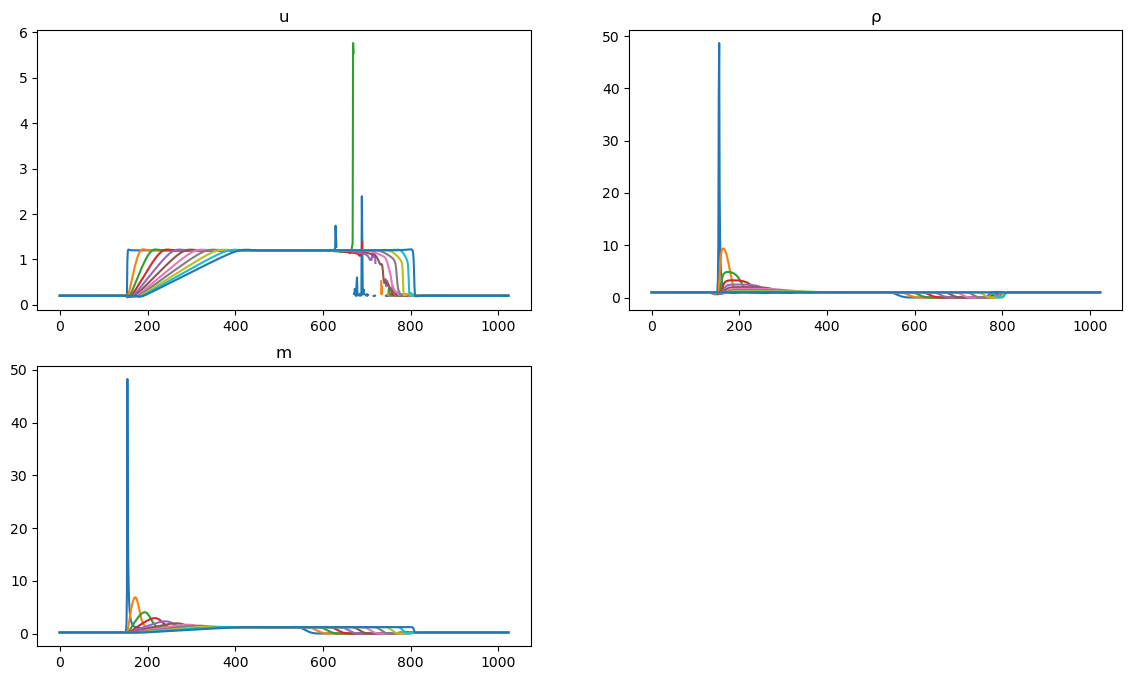

In [64]:
#Nt=512n Nx=1024, tau_f=1/40, maxiter=20000
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//10): plt.plot(var[i])

## 4. Double step

Ca ne semble pas bien fonctionner sur les temps longs...

CPU times: total: 57.5 s
Wall time: 1min


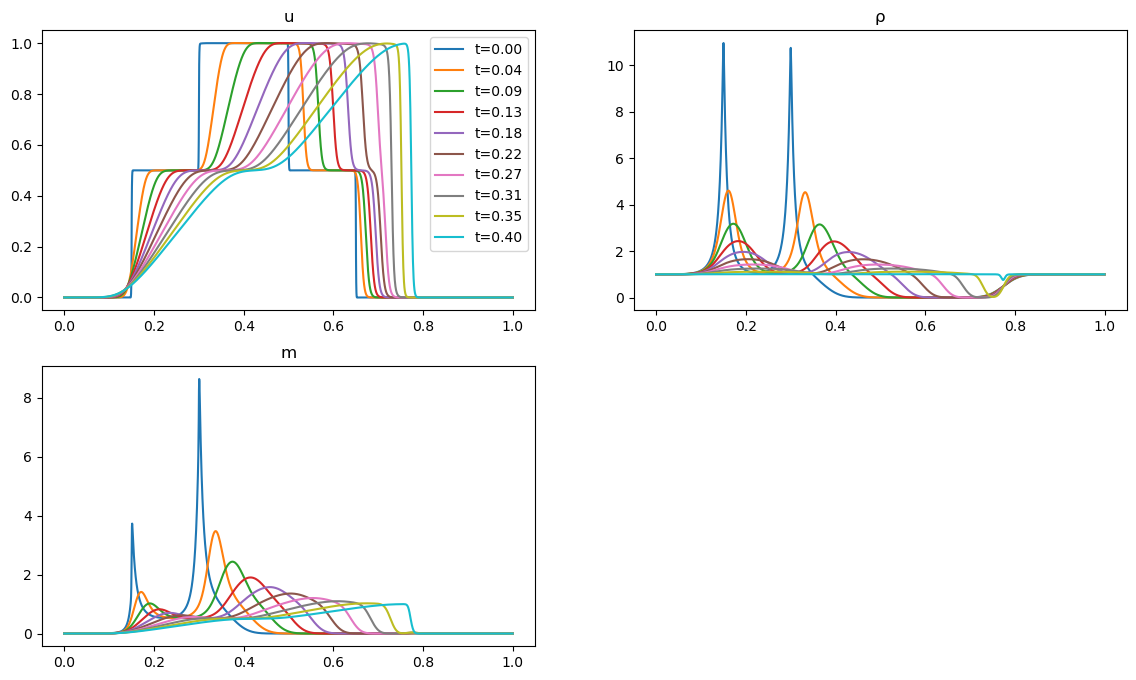

In [113]:
%%time
nT = 1024; nX=2048; maxiter=5000
t0 = 0.0 # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.4
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-3

u0 = 0.5*(np.logical_and(0.15<=X,X<0.65).astype(float)+np.logical_and(0.30<=X,X<0.5))

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1/20,maxiter=maxiter)

m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

fig = plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//9): plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if name=='u': plt.legend()
    savefig(fig,f'doublestep_{aname(name)}_{nT=}_{nX=}_{maxiter=}.png',ax=ax)

If the time is longer, then $\rho$ becomes very small, and convergence is not achieved.

C:\Users\jmmir\AppData\Local\Temp\ipykernel_42224\500644126.py:22: RuntimeWarning: divide by zero encountered in divide
  iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
<timed exec>:18: RuntimeWarning: divide by zero encountered in divide
<timed exec>:18: RuntimeWarning: invalid value encountered in divide


CPU times: total: 5min 42s
Wall time: 6min


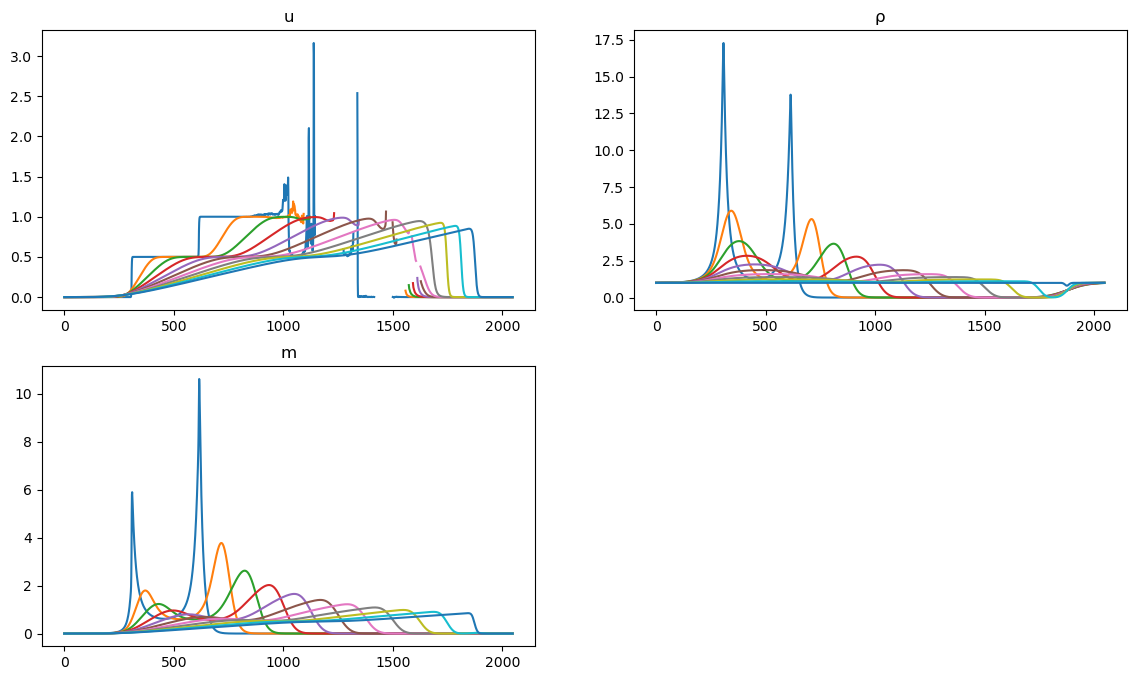

In [74]:
%%time
nT = 2048
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.8
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 2048
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-3

u0 = 0.5*(np.logical_and(0.15<=X,X<0.65).astype(float)+np.logical_and(0.30<=X,X<0.5))

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1/20,maxiter=15000)

m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//10): plt.plot(var[i])

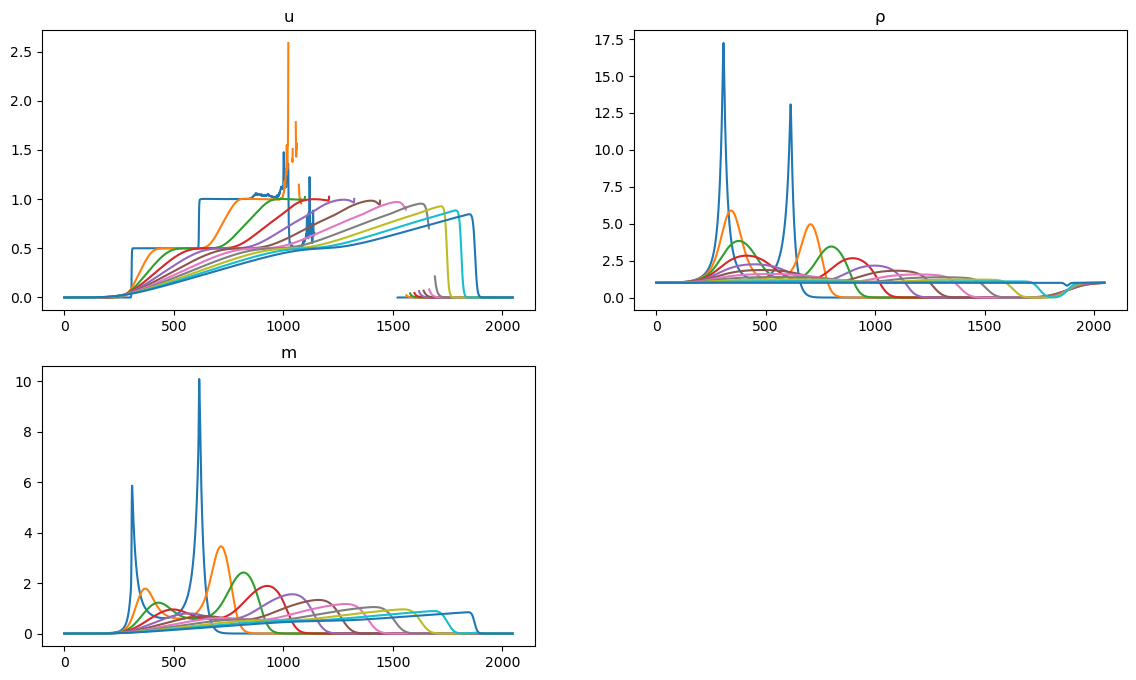

In [72]:
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in range(0,len(u),len(u)//10): plt.plot(var[i])

CPU times: total: 1min 32s
Wall time: 1min 35s


C:\Users\jmmir\AppData\Local\Temp\ipykernel_23520\500644126.py:22: RuntimeWarning: divide by zero encountered in divide
  iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
<timed exec>:18: RuntimeWarning: divide by zero encountered in divide
<timed exec>:18: RuntimeWarning: invalid value encountered in divide


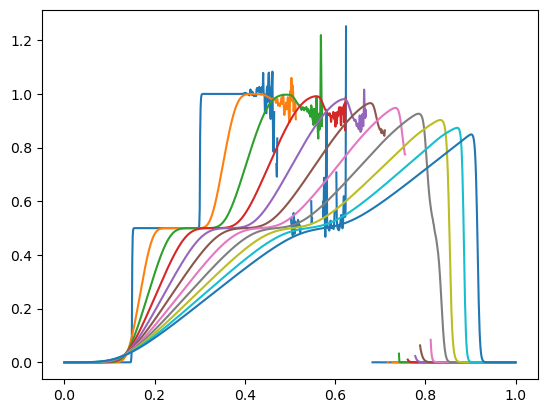

In [79]:
%%time
nT = 1024
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 0.8
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 1024
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-3

u0 = 0.5*(np.logical_and(0.15<=X,X<0.65).astype(float)+np.logical_and(0.30<=X,X<0.5))

# Initialize taichi, transfer array to GPU, and run
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1,maxiter=15000)

m0,m1,ρ,a0,a1 = [e.cpu().numpy() for e in (m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)]
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u = (m+a)/ρ

for it in range(0,len(u),len(u)//10):
    plt.plot(X,u[it])

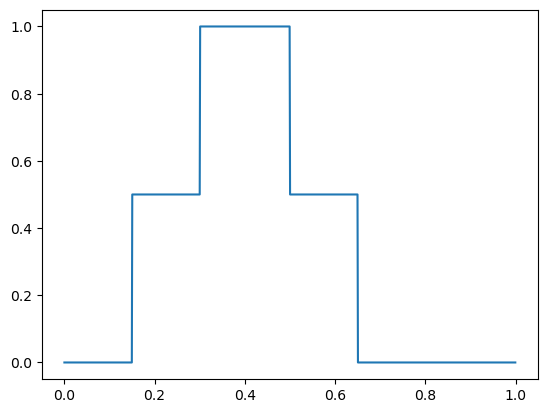

In [73]:
u0 = 0.5*(np.logical_and(0.15<=X,X<0.65).astype(float)+np.logical_and(0.30<=X,X<0.5))
plt.plot(X,u0)